In [7]:
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm
from loader_clone import create_loaders

In [8]:
loader, _ = create_loaders()

demo_genres_embeddings = np.load('demo_genres_embeddings.npy')
demo_plot_embeddings = np.load('demo_plot_embeddings.npy')

2017


c:\Users\richa\Desktop\SCHOOL\mgr\diplomka\experiment\EasyStudy\server\static\datasets\ml-latest\loader_clone.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loader.ratings_df.loc[:, "ratings_per_year"] = loader.ratings_df['movieId'].map(loader.ratings_df['movieId'].value_counts()) / loader.ratings_df['movieId'].map(movies_df_indexed["age"])


Ratings shape after filtering: (3536742, 5), n_users = 9612, n_items = 1525
2017


c:\Users\richa\Desktop\SCHOOL\mgr\diplomka\experiment\EasyStudy\server\static\datasets\ml-latest\loader_clone.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loader.ratings_df.loc[:, "ratings_per_year"] = loader.ratings_df['movieId'].map(loader.ratings_df['movieId'].value_counts()) / loader.ratings_df['movieId'].map(movies_df_indexed["age"])


Ratings shape after filtering: (8146440, 5), n_users = 34683, n_items = 9456


In [50]:

sim_matrix = cosine_similarity(demo_genres_embeddings)
triu_indices = np.triu_indices_from(sim_matrix, k=1) # avoid duplicates ij - ji
genre_sim_scores = sim_matrix[triu_indices]

sim_matrix = cosine_similarity(demo_plot_embeddings)
triu_indices = np.triu_indices_from(sim_matrix, k=1) # avoid duplicates ij - ji
plot_sim_scores = sim_matrix[triu_indices]

## Diversity phase

In diversity phase, we want to show pairs of movies that are similar in genres but different in plot, and vice versa. And let them rate how diverse they are.


### Genres 

As a pair we select the most similar movies by genre embedding (same genres) but different plot


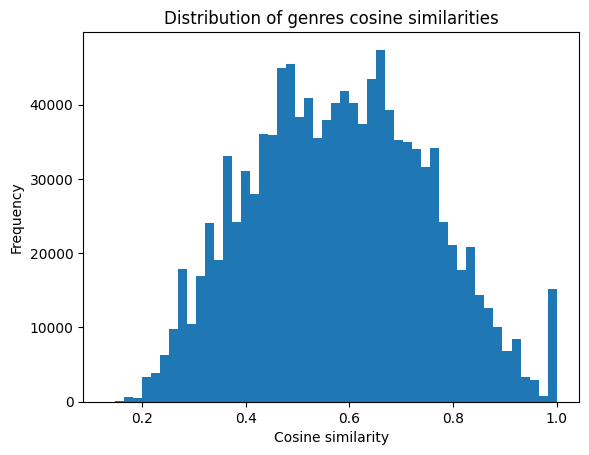

In [51]:

plt.hist(genre_sim_scores, bins=50)
plt.title("Distribution of genres cosine similarities")
plt.xlabel("Cosine similarity")
plt.ylabel("Frequency")
plt.show()

In [52]:
print("Genres")
print(f"Mean similarity: {np.mean(genre_sim_scores):.3f}")
print(f"Max similarity: {np.max(genre_sim_scores):.3f}")
print(f"Min similarity: {np.min(genre_sim_scores):.3f}")

Genres
Mean similarity: 0.582
Max similarity: 1.000
Min similarity: 0.129


In [ ]:
N = 20
threshold = 0.9

valid_indices = np.where(genre_sim_scores < threshold)[0]

top_n_valid = valid_indices[np.argsort(-genre_sim_scores[valid_indices])[:N]]

def are_same(movie_a, movie_b):
    j_parts = movie_a.split(" ")
    for i_part in movie_b.split(" "):
        for j_part in j_parts:
            if j_part.startswith(i_part) or i_part.startswith(j_part):
                return True

def wrap_text(text, width=50):
    return [text[i:i+width] for i in range(0, len(text), width)]

print(f"\nTop {N} most-similar movie pairs (sub {threshold}):")
for rank, flat_idx in enumerate(top_n_valid, start=1):
    i, j = triu_indices[0][flat_idx], triu_indices[1][flat_idx]
    plot_sim = plot_sim_scores[flat_idx]
    genre_sim = genre_sim_scores[flat_idx]
    if plot_sim > 0.5:
        continue
    title_i = loader.movies_df.iloc[i].title
    title_j = loader.movies_df.iloc[j].title
    if are_same(title_i, title_j):
        continue
    genres_i = loader.movies_df.iloc[i].genres
    genres_j = loader.movies_df.iloc[j].genres
    plot_i_wrapped = wrap_text(loader.movies_df.iloc[i]["plot"])
    plot_j_wrapped = wrap_text(loader.movies_df.iloc[j]["plot"])
    max_lines = max(len(plot_i_wrapped), len(plot_j_wrapped))
    print(f"{rank:>2}. plot_sim = {plot_sim:.3f} genre_sim = {genre_sim:.3f}")
    print(f"{title_i:<51} ----- {title_j:<51}")
    print(f"{genres_i:<51} ----- {genres_j:<51}")
    for line_idx in range(max_lines):
        left_line = plot_i_wrapped[line_idx] if line_idx < len(plot_i_wrapped) else ''
        right_line = plot_j_wrapped[line_idx] if line_idx < len(plot_j_wrapped) else ''
        print(f"{left_line:<51} ----- {right_line:<51}")


Top 20 most-similar movie pairs (sub 0.9):
 1. plot_sim = 0.300 genre_sim = 0.900
Good, the Bad and the Ugly, The (Buono, il brutto, il cattivo, Il) (1966) ----- Shanghai Noon (2000)                               
Action, Adventure, Western                          ----- Action, Adventure, Comedy, Western                 
A bounty-hunting scam joins two men in an uneasy a  ----- A Chinese man travels to the Wild West to rescue a 
lliance against a third in a race to find a fortun  -----  kidnapped Princess. After teaming up with a train 
e in gold buried in a remote cemetery.              -----  robber, the unlikely duo takes on a Chinese trait 
                                                    ----- or and his corrupt boss.                           
 2. plot_sim = -0.015 genre_sim = 0.900
North by Northwest (1959)                           ----- Mummy Returns, The (2001)                          
Action, Adventure, Mystery, Romance, Thriller       ----- Action, Adventure, Comedy, 

### Same for plot ?

Well ...

#### Detour, normalization of similarity for plots

Noticed that the similarity for plots tends to be in between 0.3 and 0.5, and very few movies have similarity above or below that range. Since genre similarity is defined in 0-1 range, we should normalize the plot similarity to be in the same range.

First we analyze the distribution of plot similarity values.



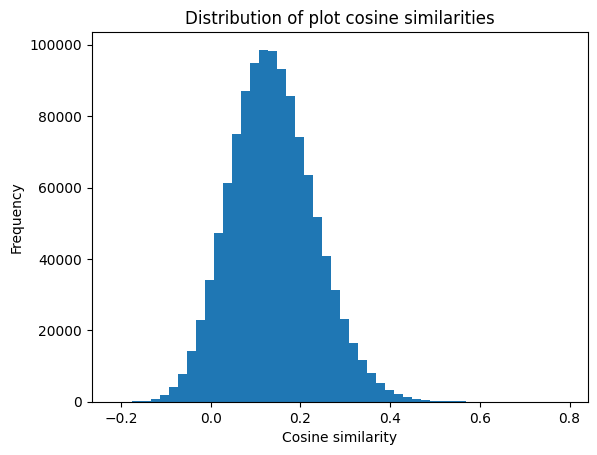

In [64]:

plt.hist(plot_sim_scores, bins=50)
plt.title("Distribution of plot cosine similarities")
plt.xlabel("Cosine similarity")
plt.ylabel("Frequency")
plt.show()

In [65]:
print("Plots")
print(f"Mean similarity: {np.mean(plot_sim_scores):.3f}")
print(f"Max similarity: {np.max(plot_sim_scores):.3f}")
print(f"Min similarity: {np.min(plot_sim_scores):.3f}")

N = 300
threshold = 0.5

valid_indices = np.where(plot_sim_scores > threshold)[0]

top_n_valid = valid_indices[np.argsort(-plot_sim_scores[valid_indices])[:N]]

def are_same(movie_a, movie_b):
    j_parts = movie_a.split(" ")
    for i_part in movie_b.split(" "):
        for j_part in j_parts:
            if j_part.startswith(i_part) or i_part.startswith(j_part):
                return True

def wrap_text(text, width=50):
    return [text[i:i+width] for i in range(0, len(text), width)]

print(f"\nTop {N} most-similar movie pairs (sub {threshold}):")
for rank, flat_idx in enumerate(top_n_valid, start=1):
    i, j = triu_indices[0][flat_idx], triu_indices[1][flat_idx]
    plot_sim = plot_sim_scores[flat_idx]
    genre_sim = genre_sim_scores[flat_idx]
    if genre_sim > 0.5:
        continue
    title_i = loader.movies_df.iloc[i].title
    title_j = loader.movies_df.iloc[j].title
    if are_same(title_i, title_j):
        continue
    genres_i = loader.movies_df.iloc[i].genres
    genres_j = loader.movies_df.iloc[j].genres
    plot_i_wrapped = wrap_text(loader.movies_df.iloc[i]["plot"])
    plot_j_wrapped = wrap_text(loader.movies_df.iloc[j]["plot"])
    max_lines = max(len(plot_i_wrapped), len(plot_j_wrapped))
    print(f"{rank:>2}. plot_sim = {plot_sim:.3f} genre_sim = {genre_sim:.3f}")
    print(f"{title_i:<51} ----- {title_j:<51}")
    print(f"{genres_i:<51} ----- {genres_j:<51}")
    for line_idx in range(max_lines):
        left_line = plot_i_wrapped[line_idx] if line_idx < len(plot_i_wrapped) else ''
        right_line = plot_j_wrapped[line_idx] if line_idx < len(plot_j_wrapped) else ''
        print(f"{left_line:<51} ----- {right_line:<51}")

# Where the Buffalo Roam (1980) ------ Gonzo: The Life and Work of Dr. Hunter S. Thompson (2008)
# Prince of Egypt, The (1998) ------ Ten Commandments, The (1956)
# In Order of Disappearance (Kraftidioten) (2014) ------ Cold Pursuit (2019)




Plots
Mean similarity: 0.138
Max similarity: 0.791
Min similarity: -0.215

Top 300 most-similar movie pairs (sub 0.5):
79. plot_sim = 0.625 genre_sim = 0.388
Sleeping Beauty (1959)                              ----- Pan's Labyrinth (Laberinto del fauno, El) (2006)   
Animation, Children, Musical                        ----- Drama, Fantasy, Thriller                           
After being snubbed by the royal family, a malevol  ----- In 1944 Spain, a girl is sent to live with her rut 
ent fairy places a curse on a princess which only   ----- hless stepfather. During the night, she meets a fa 
a prince can break, along with the help of three g  ----- iry who takes her to an old faun. He tells her she 
ood fairies.                                        ----- &#x27;s a princess, but must prove her royalty by  
                                                    ----- surviving three gruesome tasks.                    
108. plot_sim = 0.606 genre_sim = 0.396
Mission: Impossible (1996)      

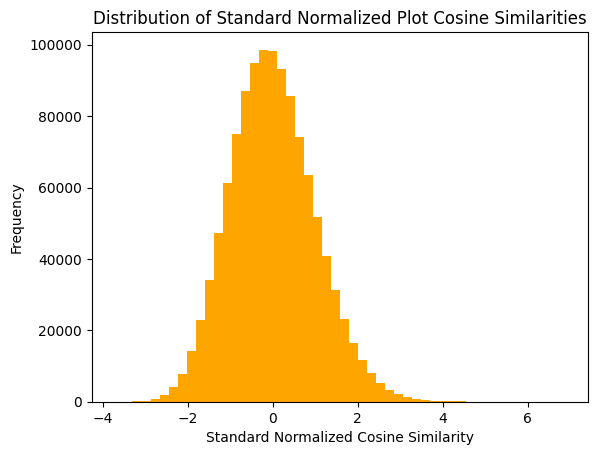

In [56]:
sim_scores_reshaped = sim_scores.reshape(-1, 1)
scaler = StandardScaler() # for z-score normalization (also called standardization)
sim_scores_std = scaler.fit_transform(sim_scores_reshaped).flatten()

plt.hist(sim_scores_std, bins=50, color='orange')
plt.title("Distribution of Standard Normalized Plot Cosine Similarities")
plt.xlabel("Standard Normalized Cosine Similarity")
plt.ylabel("Frequency")
plt.show()

In [57]:
# NOT WORKING...
# def similarity_percentile(raw_sim, scaler):
#     """Return percentile (0–1) of a similarity score"""
#     z = scaler.transform([[raw_sim]])[0, 0]
#     return norm.cdf(z)

# NOT WORKING...
# def similarity_percentile(raw_sim, sample_scores):
#     return np.mean(sample_scores < raw_sim)

min_sim = sim_scores.min()
max_sim = sim_scores.max()

def similarity_score(raw_sim, min_val, max_val):
    return (raw_sim - min_val) / (max_val - min_val + 1e-8)



The distribution is bell shaped - we can use z-score normalization to map the values to 0-1 range. 



In [58]:
movies = loader.movies_df

genre_movie_ids = [858, 2571, 8961, 69406, 69458]

genre_movies = movies[movies['movieId'].isin(genre_movie_ids)]
genre_movies

,movieId,title,genres,plot,year
98,858,"Godfather, The (1972)","Crime, Drama",The aging patriarch of an organized crime dyna...,1972
324,2571,"Matrix, The (1999)","Action, Sci-Fi, Thriller",When a beautiful stranger leads computer hacke...,1999
671,8961,"Incredibles, The (2004)","Action, Adventure, Animation, Children, Comedy","While trying to lead a quiet suburban life, a ...",2004
917,69406,"Proposal, The (2009)","Comedy, Romance",When New York editor Margaret faces deportatio...,2009


In [59]:
def find_most_similar(movie_id, base_embeddings, alt_embeddings, movies_df):
    index = movies_df[movies_df['movieId'] == movie_id].index[0]
    base_embedding = base_embeddings[index]
    alt_embedding = alt_embeddings[index]

    # Compute cosine similarity
    similarities = cosine_similarity([base_embedding], base_embeddings).flatten()

    # Set self-similarity to -1 to ignore it when taking the argmax
    similarities[index] = -1

    nearest_index = np.argmax(similarities)
    similar_movie = movies_df.iloc[nearest_index]
    base_similarity = similarities[nearest_index]

    alt_similarity = cosine_similarity([alt_embedding], [alt_embeddings[nearest_index]])[0][0]
    input_movie = movies_df[movies_df['movieId'] == movie_id]
    print(f"Input movie: {input_movie['title'].values[0]} (ID: {movie_id})")
    print(f"Most similar movie: {similar_movie['title']} (ID: {similar_movie['movieId']})")
    print(f"Input movie genres: {input_movie['genres'].values[0]}")
    print(f"Most similar movie genres: {similar_movie['genres']}")
    print(f"Input movie plot: {input_movie['plot'].values[0]}")
    print(f"Most similar movie plot: {similar_movie['plot']}")

    return similar_movie['movieId'], similar_movie['title'], base_similarity, alt_similarity

def print_similarity_info_genres(movie_ids, genre_embeddings, plot_embeddings, movies_df, min_sim, max_sim):
    for movie_id in movie_ids:
        similar_id, similar_title, genre_sim, plot_sim = find_most_similar(
            movie_id, genre_embeddings, plot_embeddings, movies_df
        )

        score = similarity_score(plot_sim, min_sim, max_sim)

        print(f"{movie_id}\t{similar_id}\t{similar_title[:20]:<20}\tGenreSim: {genre_sim:.4f}\tPlotSim: {plot_sim:.4f} MinMax: {score:.4f}\n")

def print_similarity_info_plot(movie_ids, plot_embeddings, genre_embeddings, movies_df, min_sim, max_sim):
    for movie_id in movie_ids:
        similar_id, similar_title, plot_sim, genre_sim = find_most_similar(
            movie_id, plot_embeddings, genre_embeddings, movies_df
        )

        score = similarity_score(plot_sim, min_sim, max_sim)

        print(f"{movie_id}\t{similar_id}\t{similar_title[:20]:<20}\tGenreSim: {genre_sim:.4f}\tPlotSim: {plot_sim:.4f} MinMax: {score:.4f}\n")


In [60]:
        
print("GENRE PAIRS")
print_similarity_info_genres(genre_movie_ids, demo_genres_embeddings, demo_plot_embeddings, loader.movies_df, min_sim, max_sim)

GENRE PAIRS
Input movie: Godfather, The (1972) (ID: 858)
Most similar movie: Casino (1995) (ID: 16)
Input movie genres: Crime, Drama
Most similar movie genres: Crime, Drama
Input movie plot: The aging patriarch of an organized crime dynasty transfers control of his clandestine empire to his reluctant son.
Most similar movie plot: In Las Vegas, two best friends--a casino executive and a Mafia enforcer--compete for a gambling empire and a fast-living, fast-loving socialite.
858	16	Casino (1995)       	GenreSim: 1.0000	PlotSim: 0.2206 MinMax: 0.4330

Input movie: Matrix, The (1999) (ID: 2571)
Most similar movie: Blade Runner (1982) (ID: 541)
Input movie genres: Action, Sci-Fi, Thriller
Most similar movie genres: Action, Sci-Fi, Thriller
Input movie plot: When a beautiful stranger leads computer hacker Neo to a forbidding underworld, he discovers the shocking truth--the life he knows is the elaborate deception of an evil cyber-intelligence.
Most similar movie plot: A blade runner must purs

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
print("PLOT PAIRS")
print_similarity_info_plot(genre_movie_ids, demo_plot_embeddings, demo_genres_embeddings, loader.movies_df, min_sim, max_sim)

PLOT PAIRS
Crime, Drama, Mystery, Thriller
Follows Michael Corleone, now in his 60s, as he seeks to free his family from crime and find a suitable successor to his empire.
858	2023	Godfather: Part III,	GenreSim: 0.7630	PlotSim: 0.5636 MinMax-0.6563

Action, Crime, Thriller
A computer programmer stumbles upon a conspiracy, putting her life and the lives of those around her in great danger.
2571	185	Net, The (1995)     	GenreSim: 0.8713	PlotSim: 0.6108 MinMax-0.6935

Action, Comedy, Fantasy
A group of inept amateur superheroes must try to save the day when a supervillain threatens to destroy a major superhero and the city.
8961	2723	Mystery Men (1999)  	GenreSim: 0.7849	PlotSim: 0.6491 MinMax-0.7236

Comedy, Drama
Soon after her divorce, a fiction writer returns to her home in small-town Minnesota, looking to rekindle a romance with her ex-boyfriend who is now happily married and has a newborn daughter.
69406	91622	Young Adult (2011)  	GenreSim: 0.7875	PlotSim: 0.4760 MinMax-0.5873

Docu